In [2]:
import warnings
#warnings.simplefilter(action='ignore', category=[FutureWarning, DeprecationWarning, UserWarning])
import wandb
import pandas as pd
import os 
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import string

In [3]:

data_dump_path = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/results/rundata.xlsx'
run_details_sheet = "Run Details"
loss_sheet = "Loss"
blimp_sheet = "BLIMP"
rt_sheet = "Reading Time"

run_data = pd.read_excel(data_dump_path, sheet_name=run_details_sheet)
loss_data = pd.read_excel(data_dump_path, sheet_name=loss_sheet)
blimp_data = pd.read_excel(data_dump_path, sheet_name=blimp_sheet)
rt_data = pd.read_excel(data_dump_path, sheet_name=rt_sheet)
rt_subj_data = pd.read_excel(data_dump_path, sheet_name="Reading Time Subjectwise")
#Filter only for seed 1337 (defaul seed used before Multiseed experiments)
run_data_unfiltered = run_data
run_data = run_data[run_data["seed"] == 1337]

run_data

,run_id,output_folder_name,n_layer,n_head,block_size,n_embd,batch_size,learning_rate,seed,masking,...,curriculum_type,dataset,log_exists,output_exists,ckpt_exists,sample_exists,blimp_exists,wandb_exists,reading_time_exists,model_surprisal_data_exists
0,5444724,out-babylm_full_bpe-4x4-nomask-5444724,4,4,128,256,32.0,0.0010,1337,False,...,NaN,babylm_full_bpe,True,True,True,False,True,True,True,True
1,5445338,out-babylm_wocdes_full_bpe-4x4-nomask-5445338,4,4,128,256,32.0,0.0005,1337,False,...,NaN,babylm_wocdes_full_bpe,True,True,True,False,True,True,True,True
2,5492054,out-babylm_full_bpe-8x8-nomask-5492054,8,8,512,512,32.0,0.0005,1337,False,...,NaN,babylm_full_bpe,True,True,True,True,True,True,True,True
3,5492134,out-babylm_full_bpe-6x6-nomask-5492134,6,6,256,384,32.0,0.0005,1337,False,...,NaN,babylm_full_bpe,True,True,True,True,True,True,True,True
4,5496426,out-babylm_full_bpe_8k-8x8-nomask-5496426,8,8,512,512,32.0,0.0005,1337,False,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,6810326,out-babylm_full_bpe_8k-6x6-mask_lin_em01-6810326,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True
89,6849723,out-babylm_full_bpe_8k-6x6-mask_ee2000_em01-68...,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True
90,6849725,out-babylm_full_bpe_8k-6x6-mask_ee2000_em05-68...,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True
91,6864685,out-babylm_full_bpe_8k-6x6-mask_ee2000_em10-68...,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True


In [4]:
TASKS = {
    "blimp": ["anaphor_agreement.json", "argument_structure.json", "binding.json",
              "control_raising.json", "determiner_noun_agreement.json", "ellipsis.json",
              "filler_gap.json", "irregular_forms.json", "island_effects.json",
              "npi_licensing.json", "quantifiers.json", "subject_verb_agreement.json"],
    "supplement": ["hypernym.json", "qa_congruence_easy.json", "qa_congruence_tricky.json",
               "subject_aux_inversion.json", "turn_taking.json"]
}
blimp_categories = [[x.split(".json")[0], "blimp"] for x in TASKS["blimp"]]
blimp_categories.extend([[x.split(".json")[0], "supplement"] for x in TASKS["supplement"]])

blimp_name_map = {
    "anaphor_agreement": "Anaphor Agreement", "argument_structure": "Argument Structure", "binding": "Binding", "control_raising": "Control Raising",
    "determiner_noun_agreement": "Determiner Noun Agreement", "ellipsis": "Ellipsis", "filler_gap": "Filler Gap", "irregular_forms": "Irregular Forms",
    "island_effects": "Island Effects", "npi_licensing": "NPI Licensing", "quantifiers": "Quantifiers", "subject_verb_agreement": "Subject Verb Agreement",
    "hypernym": "Hypernym", "qa_congruence_easy": "QA Congruence Easy", "qa_congruence_tricky": "QA Congruence Tricky",
    "subject_aux_inversion": "Subject Aux Inversion", "turn_taking": "Turn Taking"
}

In [5]:
def save_matplot_fig(fig, save_name, dpi=300):
    #path = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/results/log_analyser'
    path = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/results/final_figures'
    path = os.path.join(path, save_name)
     
    #If extension is not provided, add it as pdf
    if not path.endswith(".pdf"):
        if not (path.endswith(".png") or path.endswith(".jpg") or path.endswith(".jpeg")):
            path = path + ".pdf"
                
    inp = input(f"Saving figure to {path}. Press Enter to continue, or type 'n' to cancel: ")
    if inp.lower() == 'n':
        print("Figure not saved")
        return
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    

In [6]:
#Settings for plots

#one_columns = (10, 5)
#two_columns = (10, 10)

params_one_col = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
}

params_two_col = {
    'axes.labelsize': 8,
    'font.size': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [12, 4.5],
    'figure.constrained_layout.use': True
}

sns.set(style='ticks', palette='Set2')
#sns.set(style="ticks", palette="Set2") #For Prettyplotlib style
sns.set_context("paper", font_scale = 2)

#sns.despine() # (where necessary or desirable) 

/tmp/ipykernel_3177421/1832818098.py:138: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  plot_loss2["x_label"] = plot_loss2["mask_type"].replace({"linear": "Linear",
/tmp/ipykernel_3177421/1832818098.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels = ax[0].get_xticklabels())
/tmp/ipykernel_3177421/1832818098.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([x.get_text().replace("Exponential", "Decay\nRate\n") for x in ax[1].get_xticklabels()])


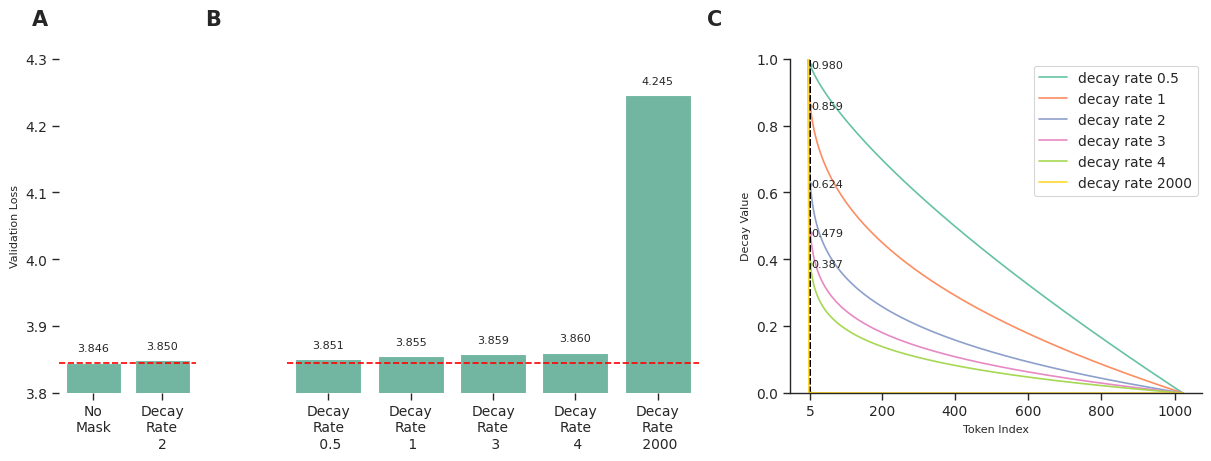

In [7]:
def ret_chart_3(fig, axr, option_1=True):
    def get_decay_weight_matrix( n, decay_length, decay_factor=None, decay_type=None, decay_echoic_memory=1):
        
        """
        Get a decay weight matrix for a given context window size n.
        :param n: Context window size for the decay matrix
        :param decay_length: Actual length over which decay happens (usually is supposed to be equal to or greater than n) 
        :param decay_factor: Decay factor for the decay matrix, analogous to weight of the decay
        :param decay_type: Type of decay to apply to the matrix #linear, exponential, inverse_sigmoid, custom_logistic
        :param decay_echoic_memory: Echoic memory for the decay matrix, first n values where "effect of decay" is not applied, where memory is supposedly perfect
        :return: 
        """    
    
        if decay_type == 'linear':
            decay_length = decay_length - decay_echoic_memory+1
            decay_values = torch.linspace(1, 0, decay_length)
            decay_values = torch.cat((torch.ones(decay_echoic_memory-1), decay_values))
            decay_length = decay_length+decay_echoic_memory-1
            if decay_length != n:
                assert decay_length > n  #n is context window size and ideally we want decay length to be larger because we are going to cut it off
                decay_values = decay_values[:n] #Cut off the decay values to the context window size

        elif decay_type == 'exponential':
            decay_length = decay_length - decay_echoic_memory + 1
            nums = torch.linspace(0, 1, decay_length)
            decay_values = torch.exp(-nums * decay_factor)
            decay_values = torch.cat((torch.ones(decay_echoic_memory-1), decay_values))
            decay_length = decay_length+decay_echoic_memory-1
            if decay_length != n:
                assert decay_length > n
                decay_values = decay_values[:n]
    
        elif decay_type == "inverse_sigmoid":
            decay_length = decay_length - decay_echoic_memory + 1 
            nums = torch.linspace(10, -10, decay_length) #assuming hardcoded range between 10 and -10 for now
            decay_values = 1/(1+torch.exp(-decay_factor*nums))
            decay_values = torch.cat((torch.ones(decay_echoic_memory-1), decay_values))
            decay_length = decay_length+decay_echoic_memory-1

            if decay_length != n:
                assert decay_length > n
                decay_values = decay_values[:n]
        
        elif decay_type == "logarithmic":
            decay_length = decay_length - decay_echoic_memory + 1
            nums = torch.linspace(0, 1, decay_length)   
            decay_values = 1-torch.pow(nums,np.e*decay_factor)
            decay_values = torch.cat((torch.ones(decay_echoic_memory-1), decay_values))
            decay_length = decay_length+decay_echoic_memory-1
            if decay_length != n:
                assert decay_length > n
                decay_values = decay_values[:n]
        
        elif decay_type == "exponential_2":
            decay_length = decay_length - decay_echoic_memory + 1
            nums = torch.linspace(0, 1, decay_length)
            decay_values = 1 - torch.pow(nums, 1/(np.e*decay_factor))
            decay_values = torch.cat((torch.ones(decay_echoic_memory-1), decay_values))
            decay_length = decay_length+decay_echoic_memory-1
            if decay_length != n:
                assert decay_length > n
                decay_values = decay_values[:n]
                
                
        elif decay_type == "custom_logistic":
            A = 0  # Lower asymptote
            K = 1  # Upper asymptote
            B = 0.8  # Growth rate
            Q = 125  # Related to value at x=0
            nu = 4  # Shape parameter
            M = 4  # Inflection point (time of max growth)
            
            decay_length = decay_length - decay_echoic_memory + 1
            x = torch.linspace(-10, 14.5, decay_length)
            decay_values = A + (K - A) / (1 + Q * torch.exp(-B * (x - M))) ** (1 / nu)
            decay_values = torch.flip(decay_values, [0])
            decay_values = torch.cat((torch.ones(decay_echoic_memory-1), decay_values))
            decay_length = decay_length+decay_echoic_memory-1
            if decay_length != n:
                assert decay_length > n
                decay_values = decay_values[:n]
    
        # Apply the decay values to the lower triangle
    
        indices = torch.arange(n)[:, None] - torch.arange(n)
        lower_triangle = torch.tril(decay_values[indices])
        lower_triangle = lower_triangle.float()
    
        return lower_triangle
    if option_1:
        for i in [1]:
            for dt in ['exponential_2']:
                color_map = sns.color_palette("Set2", 6)
                decay_rate_list = [0.5, 1, 2, 3, 4, 2000]
                for j in decay_rate_list:
                    d_vals = get_decay_weight_matrix(1024, 1024, decay_factor=j, decay_type=dt, decay_echoic_memory=i)
                    plot_vals = d_vals[-1]
                    plot_vals = plot_vals.flip([0])
                    #Annotate 5th value in each curve of the plot using arrow 
                    axr.annotate(f'{plot_vals[5]:.3f}', (8, plot_vals[5]-0.01) ) 
                    axr.plot(5, plot_vals[5], ".")
                    axr.axvline(x=5, color='black', linestyle='--')
                    sns.lineplot(plot_vals, label=f"Decay rate {j}", ax=axr, color=color_map[decay_rate_list.index(j)])
            axr.set_xlabel('Index')
            axr.set_ylabel('Decay Value')
            axr.set_xticks(axr.get_xticks().tolist()[2:-1]+[5])
            axr.set_ylim(0, 1)
            
            axr.legend(axr.get_legend_handles_labels()[0], ["decay rate 0.5", "decay rate 1", "decay rate 2", "decay rate 3", "decay rate 4", "decay rate 2000"], bbox_to_anchor=(0.575, 1), loc='upper left')
    else:
        annotate_x = [6,6,6,6]
        annotate_y = [0.01, 0.035, 0.06, 0.075]
        for dt, decay_rate_list in [("linear", 1), ("logarithmic", 0.5), ("logarithmic", 1), ("logarithmic", 2)]:
            d_vals = get_decay_weight_matrix(256, 256, decay_factor=decay_rate_list, decay_type=dt, decay_echoic_memory=1)
            plot_vals = d_vals[-1]
            plot_vals = plot_vals.flip([0])
            
            axr.annotate(f'{plot_vals[5]:.3f}', (annotate_x.pop(), plot_vals[5]-annotate_y.pop()) )
            axr.plot(5, plot_vals[5], ".")
            axr.axvline(x=5, color='black', linestyle='--')
            sns.lineplot(plot_vals, label=f"{dt} Decay Rate {decay_rate_list}", ax=axr)
            
        axr.set_xlabel('Index')
        axr.set_ylabel('Decay Value')
        axr.set_xticks(axr.get_xticks().tolist()[2:-1]+[5])
        axr.set_ylim(0, 1)
        axr.legend(axr.get_legend_handles_labels()[0], ["Linear", "Logarithmic Decay Rate 0.5", "Logarithmic Decay Rate 1", "Logarithmic Decay Rate 2"],  loc='lower left')
        

    return axr

plot_loss2 = run_data[(run_data["curriculum_learning"]==False) & (run_data["dataset"] == "babylm_full_bpe_8k") & (run_data["echoic_memory"]==1) &
                      (~run_data["mask_type"].isin(["exponential", "sigmoid"])) & (run_data["n_layer"]==6)][["run_id", "output_folder_name", "mask_type", "mask_decay_rate", "echoic_memory" ]].assign(mask_type=lambda x: pd.Categorical(x["mask_type"], categories=["Non", "linear", "exponential_new", "logarithmic", "sigmoid"], ordered=True)).sort_values(by=["mask_type", "mask_decay_rate"])
plot_loss2 = plot_loss2[~plot_loss2["run_id"].isin([5734459, 5496427, 6617787])]
plot_loss2 = plot_loss2.merge(loss_data, on="run_id")

#Convert string to %g for better display
plot_loss2["x_label"] = plot_loss2["mask_type"].replace({"linear": "Linear",
                                                         "logarithmic": "Logarithmic",
                                                         "Non": "No Mask",
                                                         "sigmoid": "Sigmoid",
                                                         "exponential_new": "Exponential",
                                                         }).astype(str) + " " + plot_loss2["mask_decay_rate"].astype(str).replace("\.0", "", regex=True).replace("0", "")
plot_loss2_b = plot_loss2[(plot_loss2["mask_type"] == "exponential_new") & (plot_loss2["mask_decay_rate"] != 2)]
plot_loss2["x_label"] = (plot_loss2.x_label.apply(lambda x: x.rstrip("")).map({
    "No Mask ": "No\nMask",
    "Linear ": "Linear",
    "Exponential 0.5": "Weak\nExponential",
    "Exponential 1": "Intermediate\nExponential",
    "Exponential 2": "Decay\nRate\n2",
    "Logarithmic 0.5": "Weak\nLogarithmic",
    "Logarithmic 1": "Intermediate\nLogarithmic",
    "Logarithmic 2": "Strong\nLogarithmic",
}))
plot_loss2_a = plot_loss2[plot_loss2["x_label"].isin(["Decay\nRate\n2"])]
plot_loss2_a = plot_loss2[plot_loss2["x_label"].isin(["No\nMask", "Decay\nRate\n2"])]


rcParams.update(params_two_col) 
fig, ax = plt.subplots(1, 3, width_ratios=[1, 3,3])
sns.barplot(data=plot_loss2_a, x="x_label", y="val_loss", ax=ax[0])
ax[0].set_ylim(3.8, 4.3)
ax[1].set_ylim(3.8, 4.3)
color_mapper = {
                    0.5: 'tab:olive',
                    1: 'tab:green',
                    2: 'tab:orange',
                    3: 'tab:red',
                    4: 'tab:purple',
                    2000: 'tab:gray'
                }
sns.barplot(data=plot_loss2_b, x="x_label", y="val_loss", ax=ax[1])

ax[0].set_xticklabels(labels = ax[0].get_xticklabels())
ax[1].set_xticklabels([x.get_text().replace("Exponential", "Decay\nRate\n") for x in ax[1].get_xticklabels()])

ax[0].axhline(y=pd.Series(plot_loss2_a[plot_loss2_a["x_label"] == "No\nMask"]['val_loss']).values[0], color='red', linestyle='--')

ax[1].axhline(y=pd.Series(plot_loss2_a[plot_loss2_a["x_label"] == "No\nMask"]['val_loss']).values[0], color='red', linestyle='--')
ax[0].set_ylabel("Validation Loss")
ax[1].set_ylabel("")
ax[1].set_yticks([])
ax[0].set_xlabel("")
ax[1].set_xlabel("")

for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[2] = ret_chart_3(fig, ax[2])

ax[2].set_ylabel("Decay Value")
ax[2].set_xlabel("Token Index")
for n, axs in enumerate(ax.flat):
    axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, size=15, weight='bold')

sns.despine(bottom=True, left=True, ax=ax[0])
sns.despine(bottom=True, left=True, ax=ax[1])
sns.despine(ax=ax[2])
#save_matplot_fig(fig, "val_error_mask_no_mask_fig1_hq_v3", dpi=2000)
#save_matplot_fig(fig, "val_error_mask_no_mask_fig1_hq_v4.pdf", dpi=2000)

#save_matplot_fig(fig, "Fig1_val_error_masks.pdf", dpi=3000)

In [83]:
#subset data for runs with common seed and more than 1 run
# seed_df = run_df[run_df['seed'].notnull()]
# seed_df = seed_df[seed_df['seed'].duplicated(keep=False)]
# seed_df["run_id"] = seed_df["name"].apply(lambda x: x.split("run_")[-1].split("_")[0]).astype(int)

#seed_df = run_data_unfiltered[(run_data_unfiltered["seed"].notnull()
#Filter for data with mask_type as exponential_new or no mask, and no curriculum learning, and babylm_full_bpe_8k dataset, and 6 layers, and mask_decay_rate as 0, 2, 2000 for plotting comparisons of validation loss, blimp scores, and reading time

seed_df = run_data_unfiltered[run_data_unfiltered["mask_type"].isin(["exponential_new", "Non"]) & (run_data_unfiltered["curriculum_learning"]== False) & (run_data_unfiltered["dataset"] == "babylm_full_bpe_8k") & (run_data_unfiltered["n_layer"]==6) & (run_data_unfiltered["mask_decay_rate"].isin([0, 2, 2000]))].reset_index(drop=True)
#Filter out run_id = 5496427, duplicate run_id for no mask 1337 seed
seed_df = seed_df[~seed_df["run_id"].isin([5496427])].reset_index(drop=True)

seed_df["Mask Type"] = seed_df["mask_type"].replace({"Non": "No Mask", "exponential_new": "Power Law"})
seed_df["condition"] = (seed_df["mask_type"].replace({"Non": "nomask", "exponential_new": "ee"}) + seed_df["mask_decay_rate"].astype(int).astype(str).str.zfill(3).replace("000","") + "_EM" + seed_df["echoic_memory"].astype(str).str.zfill(2))
#seed_df
print(seed_df["condition"].value_counts())
seed_df.groupby(["Mask Type", "mask_decay_rate", "echoic_memory"]).size()

condition
ee002_EM05     10
ee002_EM10     10
ee002_EM01     10
ee2000_EM01    10
ee2000_EM05    10
ee2000_EM10    10
nomask_EM01    10
Name: count, dtype: int64


Mask Type  mask_decay_rate  echoic_memory
No Mask    0.0              1                10
Power Law  2.0              1                10
                            5                10
                            10               10
           2000.0           1                10
                            5                10
                            10               10
dtype: int64

In [187]:
def connect_dots(ax_obj,alpha=.4,col='grey', linewidth=2):
    """ for a given ax_object (from scatterplot or sns.stripplot or the like)
    connect the dots (arbtirary number of columns)"""
    cs=ax_obj.collections
    xcoords=np.vstack([this_cs.get_offsets()[:,0] for this_cs in cs]).T
    ycoords=np.vstack([this_cs.get_offsets()[:,1] for this_cs in cs]).T
    for (xcoord,ycoord) in zip(xcoords,ycoords):
        ax_obj.plot(xcoord,ycoord,alpha=alpha,color=col,linewidth=linewidth)

    return(ax_obj)

def fmt_boot_pval(pval,n_boots=10e4,scientific=False) -> str:
    """convertr bootstrap pvalues to expression that takes into account precision
    (e.g. p=0 will become p < x, with x being determined by number of bootstraps)"""
    if scientific:
        p_str= f'p={pval}' if pval>0 else f'p < {round(1/float(n_boots),int(np.log10(n_boots)+1))}'
    else:
        if pval>0:p_str=f'p={pval}'
        else:p_str='p < {atleast:.{decim}f}'.format(atleast=1/float(n_boots),decim=int(np.log10(n_boots)))
    return(p_str)

def bootstrap_t_onesample(samps_in,pop_mean=0,tail='2s',n_boots=10e4,seed=123):
    """one-sample (paired) bootstrap t-test; returns p-value only

    in:
    - samps: nd.array, shape(n_samples)
        datapoints
    - pop_mean: float, Default=0
        mean to test against
    - tail: str, default: '2s'
        options: '2s','l','r' (for two-tailed,left or right-tailed)
    - n_boots: int; default=10e3
        number of bootstraps (determines precision)

    out:
    -pval: float
        fraction of instances where simulated null distribution returns
        test statistic that is at least as extreme as emprical test stat.
    see also:
    - fmt_boot_pval, function to format the pvalues, changes p=0 into P < (1/n_boots) statement
    dependencies: bootstrap from astropy
    """
    if seed is not None:
      np.random.seed(seed)
    # test stat
    t_func=lambda x,dim:(x.mean(dim)-pop_mean)/(x.std(dim)/np.sqrt(x.shape[dim]))
    # make null distribution
    null_boot_test=t_func(bootstrap(samps_in-samps_in.mean(0)+pop_mean,bootnum=int(n_boots)),1)
    emp_test=t_func(samps_in,0)
    # return p-value as probability of obtaining a test stat at least as extreme under the null
    if tail in ['2s','two','both']:
        left_pval=np.mean(null_boot_test<emp_test)
        right_pval=np.mean(null_boot_test>emp_test)
        return(2*min(left_pval,right_pval))
    elif tail.lower() in ['l','left']:
        return(np.mean(null_boot_test<emp_test))
    elif tail.lower() in ['r','right']:
        return(np.mean(null_boot_test>emp_test))
    else:
        raise ValueError('tail not recognised!')

def bootstrap_analysis(data, pop_mean=0, tail='2s', n_boots=10000, seed=123):
    """
    Perform bootstrap analysis including one-sample t-test and compute 95% CI for the mean.

    Parameters:
    - data (array-like): Sample data.
    - pop_mean (float): Mean to test against.
    - tail (str): Type of the test ('2s' for two-tailed, 'l' for left-tailed, 'r' for right-tailed).
    - n_boots (int): Number of bootstrap samples.
    - seed (int): Seed for the random number generator.

    Returns:
    - dict: Contains the mean, 95% CI for the mean, and formatted p-value.
    """
    if seed is not None:
      np.random.seed(seed)

    # Compute the p-value using the provided function
    p_value = bootstrap_t_onesample(data, pop_mean, tail, n_boots, seed)

    # Format the p-value
    formatted_p_value = fmt_boot_pval(p_value, n_boots)

    # Calculate the sample mean
    sample_mean = np.mean(data)

    # Generate bootstrap samples for the CI of the mean
    bootstrap_samples = bootstrap(data, bootnum=n_boots, bootfunc=np.mean)
    ci_lower, ci_upper = np.percentile(bootstrap_samples, [2.5, 97.5])

    # Compile results
    results = {
        'mean                    ': sample_mean,
        '95%_CI around mean      ': (ci_lower, ci_upper),
        'bootstrap-t-test p_value': formatted_p_value
    }

    return results

def bootstrap(data, bootnum=1000, samples=None, bootfunc=None, seed=False):
    """Performs bootstrap resampling on numpy arrays. (FUNCTION FROM ASTROPY)

    Bootstrap resampling is used to understand confidence intervals of sample
    estimates. This function returns versions of the dataset resampled with
    replacement ("case bootstrapping"). These can all be run through a function
    or statistic to produce a distribution of values which can then be used to
    find the confidence intervals.

    Parameters
    ----------
    data : numpy.ndarray
        N-D array. The bootstrap resampling will be performed on the first
        index, so the first index should access the relevant information
        to be bootstrapped.
    bootnum : int, optional
        Number of bootstrap resamples
    samples : int, optional
        Number of samples in each resample. The default `None` sets samples to
        the number of datapoints
    bootfunc : function, optional
        Function to reduce the resampled data. Each bootstrap resample will
        be put through this function and the results returned. If `None`, the
        bootstrapped data will be returned

    Returns
    -------
    boot : numpy.ndarray

        If bootfunc is None, then each row is a bootstrap resample of the data.
        If bootfunc is specified, then the columns will correspond to the
        outputs of bootfunc.

    """
    if seed != False:
        np.random.seed(seed)

    if samples is None:
        samples = data.shape[0]

    # make sure the input is sane
    if samples < 1 or bootnum < 1:
        raise ValueError("neither 'samples' nor 'bootnum' can be less than 1.")

    if bootfunc is None:
        resultdims = (bootnum,) + (samples,) + data.shape[1:]
    else:
        # test number of outputs from bootfunc, avoid single outputs which are
        # array-like
        try:
            resultdims = (bootnum, len(bootfunc(data)))
        except TypeError:
            resultdims = (bootnum,)

    # create empty boot array
    boot = np.empty(resultdims)

    for i in range(bootnum):
        bootarr = np.random.randint(low=0, high=data.shape[0], size=samples)

#         if seed != False: print(bootarr)
        if bootfunc is None:
            boot[i] = data[bootarr]
        else:
            boot[i] = bootfunc(data[bootarr])

    return boot

def get_asterisk_map(pval):
    pval_c = float(pval.split('=')[1]) if 'p=' in pval else float(pval.split('<')[1])
    if pval_c < 0.001:
        return '***'
    elif pval_c < 0.01:
        return '**'
    elif pval_c < 0.05:
        return '*'
    else:
        return pval

def annotate_plot(ax, x1, x2, y, h, asterisk):
    #Ax = ax object
    #x1, x2 = x-coordinates of the bars, give absolute bar id location 0 to n_bar-1
    #y = y-coordinate of the bar, actual value in y axis where you want bar to be placed
    #h = height of the bar
    #asterisk = string to be placed on top of the bar, *,**,***, etc.
    
    if asterisk == '':
        return
    
    #Use annotate pairs to add bars on top of specific columns
    ax = plt.gca() if ax is None else ax
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    
    if asterisk in ['*', '**', '***']:
        ax.text((x1+x2)*.5, y+h, asterisk, ha='center', va='bottom', color='black')
    else:
        ax.text((x1+x2)*.5, y+h*2, asterisk, ha='center', va='bottom', color='black', fontsize=8)


#add variable for comparison data (Validation Loss or BLIMP scores or Reading Time)
def annotate_given_colid(ax, col_id1, col_id2, plot_data, y, h, plotcolname, group_by="seed"):
    col_names = [tick.get_text() for tick in ax.get_xticklabels()]
    col_names = {i: col_name for i, col_name in enumerate(col_names)}
    #print(col_names)
    #Using the column names, get the data for each condition #Just do for 0,1 for now
    print("Comparing", col_names[col_id1], "and", col_names[col_id2])
    stats_test_subset = plot_data[plot_data["condition"].isin([col_names[col_id1], col_names[col_id2]])]
    #Get pairwise differences
    pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])

    # perform bootstrap-t-test analysis on pairwise values (https://open.lnu.se/index.php/metapsychology/article/view/2058)
    res = bootstrap_analysis(pairwise_diff.values,)#alternatively, do: tail='r' to test for delta>0 (one-sided)
    #print(res)
    #Use results to annotate the plot
    annotate_plot(ax, col_id1, col_id2, y, h, get_asterisk_map(res['bootstrap-t-test p_value']))
    return res


#ib = individual blimp
#Different way to connect dots for individual blimp scores, because pair-wise comp 

def connect_dots_ib(ax_obj,alpha=.4,col='grey', linewidth=2):
    """ for a given ax_object (from scatterplot or sns.stripplot or the like)
    connect the dots (arbtirary number of columns)"""
    cs=ax_obj.collections
    xcoords=np.vstack([this_cs.get_offsets()[:,0] for this_cs in cs]).T
    ycoords=np.vstack([this_cs.get_offsets()[:,1] for this_cs in cs]).T
    for (xcoord,ycoord) in zip(xcoords,ycoords):
        
        xcoord = [xcoord[0::2], xcoord[1::2]]
        ycoord = [ycoord[0::2], ycoord[1::2]]
        ax_obj.plot(xcoord,ycoord,alpha=alpha,color=col,linewidth=linewidth)

    return(ax_obj)

def annotate_plot_ib(ax, x1, y, h, asterisk):
    #Ax = ax object
    #x1, x2 = x-coordinates of the bars, give absolute bar id location 0 to n_bar-1
    #y = y-coordinate of the bar, actual value in y axis where you want bar to be placed
    #h = height of the bar
    #asterisk = string to be placed on top of the bar, *,**,***, etc.

    if asterisk == '':
        return

    #Use annotate pairs to add bars on top of specific columns
    ax = plt.gca() if ax is None else ax

    #ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    #Given a x1, plot within its hue
    ax.plot([x1-0.2, x1-0.2, x1+0.2, x1+0.2], [y, y+h, y+h, y], lw=1.5, c='black')

    if asterisk in ['*', '**', '***']:
        ax.text((x1+x1)*.5, y+h, asterisk, ha='center', va='bottom', color='black')
    else:
        ax.text((x1+x1)*.5, y+h*2, asterisk, ha='center', va='bottom', color='black', fontsize=8)

def annotate_given_colid_ib(ax, col_id1, plot_data, y, h, conditional_map):

    col_names = [tick.get_text() for tick in ax.get_xticklabels()]
    col_names = {i: col_name for i, col_name in enumerate(col_names)}

    #Annotate within hue 
    #res = annotate_given_colid(ax, 0, 1, plot_data, 90, 2, "score", col_names[0])

    stats_test_subset = plot_data[plot_data["condition"].isin(conditional_map.values())][["condition", "seed", "score"]][plot_data["blimp_task"] == col_names[col_id1]]

    pairwise_diff = stats_test_subset.groupby('seed').apply(lambda x: x[x['condition']==list(conditional_map.values())[1]]["score"].values[0] - x[x['condition']==list(conditional_map.values())[0]]["score"].values[0])

    res = bootstrap_analysis(pairwise_diff.values,)#alternatively, do: tail='r' to test for delta>0 (one-sided)
    annotate_plot_ib(ax, col_id1, y, h, get_asterisk_map(res['bootstrap-t-test p_value']))
    
    return res



Comparing Strong
Mask
No EM and No Mask
Comparing Strong
Mask
EM 5 and No Mask


/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('seed').apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])
/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('

Comparing Strong
Mask
EM 10 and No Mask
        pair_A      pair_B  mean                      \
0  nomask_EM01  ee002_EM01                  0.007328   
1  nomask_EM01  ee002_EM05                 -0.005927   
2  nomask_EM01  ee002_EM10                 -0.013513   

                          95%_CI around mean       bootstrap-t-test p_value  
0      (0.004357456564903219, 0.01030530214309719)                 p=0.0008  
1  (-0.008891927599906915, -0.0027906960248944047)                 p=0.0138  
2    (-0.017659356594086007, -0.00898563385009757)                 p=0.0012  


KeyboardInterrupt: Interrupted by user

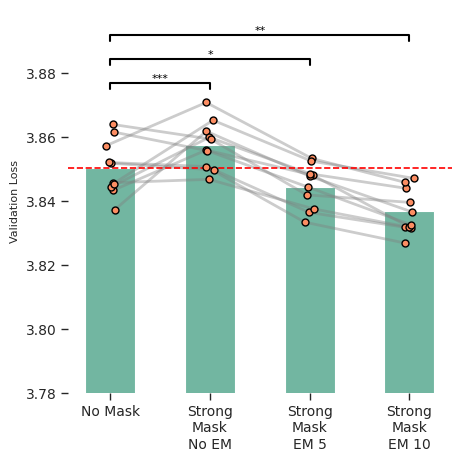

In [85]:
condition_triplet_map = {"nomask_EM01": "No Mask", 
                         "ee002_EM01": "Strong\nMask\nNo EM", 
                         "ee002_EM05": "Strong\nMask\nEM 5", 
                         "ee002_EM10": "Strong\nMask\nEM 10", 
                         "ee2000_EM01": "Extreme\nMask\nNo EM",
                         "ee2000_EM05": "Extreme\nMask\nEM 5", 
                         "ee2000_EM10": "Extreme\nMask\nEM 10"}

#fig = plt.figure(figsize=(15, 10))
rcParams.update(params_one_col)
fig, ax = plt.subplots(1, 1)
stats_test = []

row_titles = ["Validation Loss", "Train Loss"]
plot_data = seed_df.merge(loss_data, on="run_id", how="left")[["seed", "condition", "val_loss"]][seed_df["condition"].isin(["nomask_EM01", "ee002_EM01", "ee002_EM05", "ee002_EM10"])]
#Condition Order: No Mask, Exp Mask EM 0, Exp Mask EM 5, Exp Mask EM 10
plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee002_EM01", "ee002_EM05", "ee002_EM10"], ordered=True)
plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)

sns.barplot(data=plot_data, x="condition", y="val_loss", dodge=True, ax=ax, errorbar=None, width=0.5)
sns.stripplot(data=plot_data, x="condition", y="val_loss", dodge=True, jitter=0.05, ax=ax, alpha=1, edgecolor='black', linewidth=1)
connect_dots(ax)

ax.axhline(y=plot_data[plot_data["condition"]=="No Mask"]["val_loss"].mean() , linestyle='--', color='red')

ax.set_ylabel("Validation Loss")
ax.set_ylim(3.78, 3.9)  
ax.set_xlabel("")
ax.set_yticks(ax.get_yticks()[ax.get_yticks()<=3.9])
res = annotate_given_colid(ax, 1, 0, plot_data, 3.875, 0.002, "val_loss")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM01"} , **res})
res = annotate_given_colid(ax, 2, 0, plot_data, 3.8825, 0.002, "val_loss")
stats_test.append({**{ "pair_A":"nomask_EM01", "pair_B":"ee002_EM05"} ,**res})
res = annotate_given_colid(ax, 3, 0, plot_data, 3.89, 0.002, "val_loss")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM10"},**res})

sns.despine(bottom=True, left=True)

print(pd.DataFrame(stats_test))
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_mq", dpi=1000)
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_hq.pdf", dpi=3000)
save_matplot_fig(fig, "Fig2_val_loss_strong_mask_EM.pdf", dpi=3000)

Comparing Extreme
Mask
No EM and No Mask
Comparing Extreme
Mask
EM 5 and No Mask


/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('seed').apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])
/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('

Comparing Extreme
Mask
EM 10 and No Mask
        pair_A      pair_B  mean                      \
0  nomask_EM01  ee002_EM01                  0.395943   
1  nomask_EM01  ee002_EM05                  0.238320   
2  nomask_EM01  ee002_EM10                  0.178016   

                     95%_CI around mean       bootstrap-t-test p_value  
0    (0.3908613353967668, 0.4012141978740693)               p < 0.0001  
1  (0.23335518836975083, 0.24325742781162243)               p < 0.0001  
2  (0.17283720970153782, 0.18334945023059795)               p < 0.0001  


KeyboardInterrupt: Interrupted by user

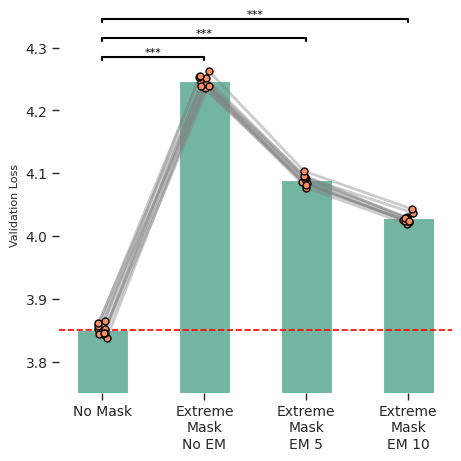

In [86]:
#fig = plt.figure(figsize=(15, 10))
rcParams.update(params_one_col)
fig, ax = plt.subplots(1, 1)
stats_test = []

plot_data = seed_df.merge(loss_data, on="run_id", how="left")[["seed", "condition", "val_loss"]][seed_df["condition"].isin(["nomask_EM01", "ee2000_EM01", "ee2000_EM05", "ee2000_EM10"])] 
#Condition Order: No Mask, Exp Mask EM 0, Exp Mask EM 5, Exp Mask EM 10
plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee2000_EM01", "ee2000_EM05", "ee2000_EM10"], ordered=True)
plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)

sns.barplot(data=plot_data, x="condition", y="val_loss", dodge=True, ax=ax, errorbar=None, width=0.5)
sns.stripplot(data=plot_data, x="condition", y="val_loss", dodge=True, jitter=0.05, ax=ax, alpha=1, edgecolor='black', linewidth=1)
connect_dots(ax)

ax.axhline(y=plot_data[plot_data["condition"]=="No Mask"]["val_loss"].mean() , linestyle='--', color='red')

ax.set_ylabel("Validation Loss")
ax.set_ylim(3.75, 4.35)  
ax.set_xlabel("")

res = annotate_given_colid(ax, 1, 0, plot_data, 4.28, 0.005, "val_loss")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM01"} , **res})
res = annotate_given_colid(ax, 2, 0, plot_data, 4.31, 0.005, "val_loss")
stats_test.append({**{ "pair_A":"nomask_EM01", "pair_B":"ee002_EM05"} ,**res})
res = annotate_given_colid(ax, 3, 0, plot_data, 4.34, 0.005, "val_loss")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM10"},**res})

sns.despine(bottom=True, left=True)

print(pd.DataFrame(stats_test))
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_mq", dpi=1000)
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_hq.pdf", dpi=3000)
save_matplot_fig(fig, "Fig3_val_loss_extreme_mask_EM.pdf", dpi=3000)


Comparing Strong
Mask
No EM and No Mask
Comparing Strong
Mask
EM 5 and No Mask


/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('seed').apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])
/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('

Comparing Strong
Mask
EM 10 and No Mask
        pair_A      pair_B  mean                      \
0  nomask_EM01  ee002_EM01                  0.175387   
1  nomask_EM01  ee002_EM05                  0.819372   
2  nomask_EM01  ee002_EM10                  1.039781   

                     95%_CI around mean       bootstrap-t-test p_value  
0  (-0.33072844503274623, 0.6691416469740857)                  p=0.536  
1   (0.43362099233637424, 1.2460334242764488)                 p=0.0006  
2     (0.5161924435294784, 1.544281033669684)                 p=0.0086  


KeyboardInterrupt: Interrupted by user

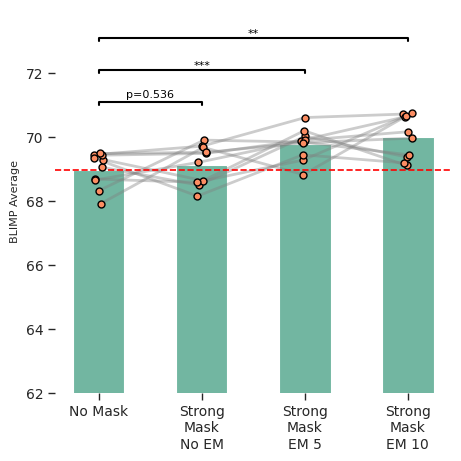

In [87]:
#fig = plt.figure(figsize=(15, 10))
rcParams.update(params_one_col)
fig, ax = plt.subplots(1, 1)
stats_test = []

plot_data = seed_df.merge(blimp_data, on="run_id", how="left")[["seed", "condition", "blimp_avg"]][seed_df["condition"].isin(["nomask_EM01", "ee002_EM01", "ee002_EM05", "ee002_EM10"])]
#Condition Order: No Mask, Exp Mask EM 0, Exp Mask EM 5, Exp Mask EM 10
plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee002_EM01", "ee002_EM05", "ee002_EM10"], ordered=True)
plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)

sns.barplot(data=plot_data, x="condition", y="blimp_avg", dodge=True, ax=ax, errorbar=None, width=0.5)
sns.stripplot(data=plot_data, x="condition", y="blimp_avg", dodge=True, jitter=0.05, ax=ax, alpha=1, edgecolor='black', linewidth=1)
connect_dots(ax)

ax.axhline(y=plot_data[plot_data["condition"]=="No Mask"]["blimp_avg"].mean() , linestyle='--', color='red')

ax.set_ylabel("BLIMP Average")
ax.set_ylim(63, 74)  
ax.set_xlabel("")

#remove yticks > 72
ax.set_yticks(ax.get_yticks()[ax.get_yticks()<=72])

res = annotate_given_colid(ax, 1, 0, plot_data, 71, 0.1, "blimp_avg")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM01"} , **res})
res = annotate_given_colid(ax, 2, 0, plot_data, 72, 0.1, "blimp_avg")
stats_test.append({**{ "pair_A":"nomask_EM01", "pair_B":"ee002_EM05"} ,**res})
res = annotate_given_colid(ax, 3, 0, plot_data, 73, 0.1, "blimp_avg")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM10"},**res})

sns.despine(bottom=True, left=True)

print(pd.DataFrame(stats_test))
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_mq", dpi=1000)
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_hq.pdf", dpi=3000)
save_matplot_fig(fig, "Fig4_blimp_strong_mask_EM.pdf", dpi=3000)


Comparing Extreme
Mask
No EM and No Mask
Comparing Extreme
Mask
EM 5 and No Mask


/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('seed').apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])
/tmp/ipykernel_1705013/2223677260.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('

Comparing Extreme
Mask
EM 10 and No Mask
        pair_A      pair_B  mean                      \
0  nomask_EM01  ee002_EM01                 -5.040100   
1  nomask_EM01  ee002_EM05                 -1.355711   
2  nomask_EM01  ee002_EM10                 -0.287335   

                     95%_CI around mean       bootstrap-t-test p_value  
0    (-5.519292462687045, -4.539908577544023)               p < 0.0001  
1  (-1.7652286911597643, -1.0004280246090378)               p < 0.0001  
2  (-0.7726558492695059, 0.20251135372643514)                 p=0.3158  


KeyboardInterrupt: Interrupted by user

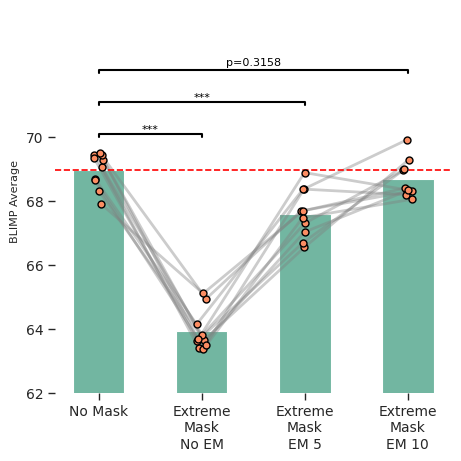

In [88]:
#fig = plt.figure(figsize=(15, 10))
rcParams.update(params_one_col)
fig, ax = plt.subplots(1, 1)
stats_test = []

plot_data = seed_df.merge(blimp_data, on="run_id", how="left")[["seed", "condition", "blimp_avg"]][seed_df["condition"].isin(["nomask_EM01", "ee2000_EM01", "ee2000_EM05", "ee2000_EM10"])]
#Condition Order: No Mask, Exp Mask EM 0, Exp Mask EM 5, Exp Mask EM 10
plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee2000_EM01", "ee2000_EM05", "ee2000_EM10"], ordered=True)
plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)

sns.barplot(data=plot_data, x="condition", y="blimp_avg", dodge=True, ax=ax, errorbar=None, width=0.5)
sns.stripplot(data=plot_data, x="condition", y="blimp_avg", dodge=True, jitter=0.05, ax=ax, alpha=1, edgecolor='black', linewidth=1)
connect_dots(ax)

ax.axhline(y=plot_data[plot_data["condition"]=="No Mask"]["blimp_avg"].mean() , linestyle='--', color='red')

ax.set_ylabel("BLIMP Average")
ax.set_ylim(63, 74)  
ax.set_xlabel("")
ax.set_yticks(ax.get_yticks()[ax.get_yticks()<=71])
res = annotate_given_colid(ax, 1, 0, plot_data, 70, 0.1, "blimp_avg")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM01"} , **res})
res = annotate_given_colid(ax, 2, 0, plot_data, 71, 0.1, "blimp_avg")
stats_test.append({**{ "pair_A":"nomask_EM01", "pair_B":"ee002_EM05"} ,**res})
res = annotate_given_colid(ax, 3, 0, plot_data, 72, 0.1, "blimp_avg")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM10"},**res})

sns.despine(bottom=True, left=True)

print(pd.DataFrame(stats_test))
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_mq", dpi=1000)
#save_matplot_fig(fig, "pairwise_comp_val_loss_withstats_v2_hq.pdf", dpi=3000)
save_matplot_fig(fig, "Fig5_blimp_extreme_mask_EM.pdf", dpi=3000)


/tmp/ipykernel_1705013/2851891860.py:269: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby('seed').apply(lambda x: x[x['condition']==list(conditional_map.values())[1]]["score"].values[0] - x[x['condition']==list(conditional_map.values())[0]]["score"].values[0])
/tmp/ipykernel_1705013/2851891860.py:269: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats

                   blimp_task       pair_A      pair_B  \
0           Anaphor Agreement  nomask_EM01  ee002_EM10   
1          Argument Structure  nomask_EM01  ee002_EM10   
2                     Binding  nomask_EM01  ee002_EM10   
3             Control Raising  nomask_EM01  ee002_EM10   
4   Determiner Noun Agreement  nomask_EM01  ee002_EM10   
5                    Ellipsis  nomask_EM01  ee002_EM10   
6                  Filler Gap  nomask_EM01  ee002_EM10   
7             Irregular Forms  nomask_EM01  ee002_EM10   
8              Island Effects  nomask_EM01  ee002_EM10   
9               NPI Licensing  nomask_EM01  ee002_EM10   
10                Quantifiers  nomask_EM01  ee002_EM10   
11     Subject Verb Agreement  nomask_EM01  ee002_EM10   

    mean                                        95%_CI around mean        \
0                   6.405930      (4.897622699386497, 8.006134969325151)   
1                   1.270611    (0.9080989330746817, 1.6306983511154214)   
2                

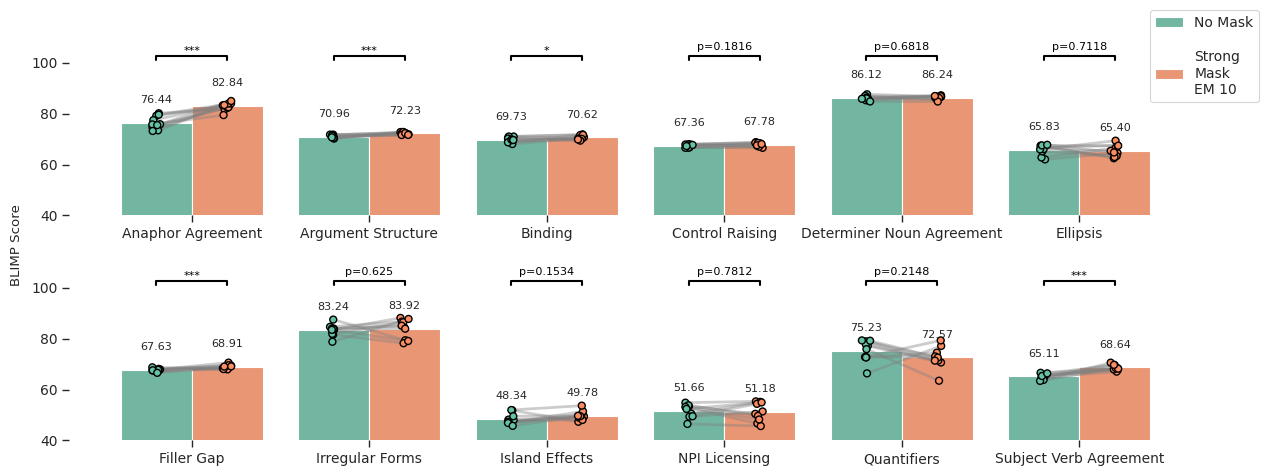

In [197]:

#Group by condition and get average of all BLIMP_avg and sort by that value
seed_df_blimp_indv = seed_df.merge(blimp_data, on="run_id", how="left")

#For this condition pair, plot all BLIMP tasks
#conditional_map = {"nomask_EM01": "No Mask", "ee002_EM10": "Exponential Mask\nEM10"}
rcParams.update(params_two_col)
fig, ax = plt.subplots(2, 1)
blimp_subtask_stats_test = []
for row, axs in enumerate(ax):
    #Split blimp categories into 2 rows of subplots
    if row == 0:
        data_columns = [i[0] for i in blimp_categories[:6]] + ["condition", "seed"]
    else:
        data_columns = [i[0] for i in blimp_categories[6:12]] + ["condition", "seed"]

    ax = axs
    plot_data = seed_df_blimp_indv[data_columns][seed_df["condition"].isin(["nomask_EM01", "ee002_EM10"])]
    plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee002_EM10"], ordered=True)
    plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)
    
    #Pivot blimp_categories into rows 
    plot_data = pd.melt(plot_data, id_vars=["condition", "seed"], value_vars=[k for k in data_columns[:-2]                                                                                ]).rename(columns={"variable": "blimp_task", "value": "score"})
    
    sns.barplot(data=plot_data, x="blimp_task", y="score" , hue="condition",
                  dodge=True, ax=ax, errorbar=None)
    
    #Add value labels to each bar slighly above the bar
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+3.5),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=8)
    
    sns.stripplot(data=plot_data, x="blimp_task", y="score", hue="condition", dodge=True, jitter=0.05, ax=ax, alpha=1, edgecolor='black', linewidth=1)
    connect_dots_ib(ax)
    
    #set title for each subplot but remove \n from mapping
    #ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(40, 115)
    #Remove legend for each subplot
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    for k in range(6):
        res = annotate_given_colid_ib(ax, k, plot_data, 101, 1.5, {x: condition_triplet_map[x] for x in ["nomask_EM01", "ee002_EM10"]})
        blimp_subtask_stats_test.append({**{"blimp_task": blimp_name_map[data_columns[k]],
                                            "pair_A":"nomask_EM01", "pair_B":"ee002_EM10"} , **res})
        
    
    #print(ax.get_xticklabels())
    ax.set_xticklabels([blimp_name_map[i.get_text()] for i in ax.get_xticklabels()])
    sns.despine(bottom=True, left=True)
handles, labels = ax.get_legend_handles_labels()
#Legend position is set to top right and overlapping with the plot
fig.legend(handles[:2], labels[:2], loc='right', bbox_to_anchor=(1.05, 0.92), labelspacing=1.5)
fig.supylabel("BLIMP Score")
print(pd.DataFrame(blimp_subtask_stats_test))
save_matplot_fig(fig, "Fig6_blimp_subtasks.pdf", dpi=3000)



In [90]:
blimp_subtask_stats_test_df = pd.DataFrame(blimp_subtask_stats_test)
blimp_subtask_stats_test_df = blimp_subtask_stats_test_df.drop(columns=["pair_A", "pair_B"])
blimp_subtask_stats_test_df = blimp_subtask_stats_test_df.rename(columns = {x:x.strip() for x in blimp_subtask_stats_test_df.columns.tolist()})
blimp_subtask_stats_test_df["95%_CI around mean"] = blimp_subtask_stats_test_df["95%_CI around mean"].apply(lambda x: f"({x[0]:.3f}, {x[1]:.3f})")
blimp_subtask_stats_test_df["bootstrap-t-test p_value"] = blimp_subtask_stats_test_df["bootstrap-t-test p_value"].apply(lambda x: x.split('=')[1] if 'p=' in x else x.split('p ')[1])

blimp_subtask_stats_test_df = blimp_subtask_stats_test_df.set_index("blimp_task").transpose()
#print(blimp_subtask_stats_test_df.head()) 
blimp_subtask_stats_test_df = blimp_subtask_stats_test_df.reset_index().rename(columns = {**blimp_name_map,"index": ""}).rename_axis(None, axis=1)

blimp_subtask_stats_test_df

print(blimp_subtask_stats_test_df.to_latex(index=False, float_format="%.3f", escape=True))

\begin{tabular}{lllllllllllll}
\toprule
 & Anaphor Agreement & Argument Structure & Binding & Control Raising & Determiner Noun Agreement & Ellipsis & Filler Gap & Irregular Forms & Island Effects & NPI Licensing & Quantifiers & Subject Verb Agreement \\
\midrule
mean & 6.406 & 1.271 & 0.892 & 0.418 & 0.123 & -0.427 & 1.284 & 0.677 & 1.439 & -0.475 & -2.661 & 3.532 \\
95\%\_CI around mean & (4.898, 8.006) & (0.908, 1.631) & (0.408, 1.358) & (-0.071, 0.864) & (-0.460, 0.766) & (-2.419, 1.726) & (0.775, 1.836) & (-1.929, 3.211) & (-0.310, 3.210) & (-3.432, 2.619) & (-5.943, 0.912) & (2.784, 4.242) \\
bootstrap-t-test p\_value & < 0.0001 & 0.0006 & 0.0258 & 0.1816 & 0.6818 & 0.7118 & 0.0004 & 0.625 & 0.1534 & 0.7812 & 0.2148 & 0.0004 \\
\bottomrule
\end{tabular}



(656, 3)
Comparing Strong
Mask
No EM and No Mask


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


Comparing Strong
Mask
EM 5 and No Mask


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


Comparing Strong
Mask
EM 10 and No Mask


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


        pair_A      pair_B  mean                      \
0  nomask_EM01  ee002_EM01                 -0.002995   
1  nomask_EM01  ee002_EM05                 -0.000027   
2  nomask_EM01  ee002_EM10                 -0.003011   

                           95%_CI around mean       bootstrap-t-test p_value  
0    (-0.004053999192423813, -0.001920194518077496)               p < 0.0001  
1    (-0.001334447014069878, 0.0015364541185655144)                 p=0.9872  
2  (-0.0040601511785457785, -0.0019314420669064472)               p < 0.0001  


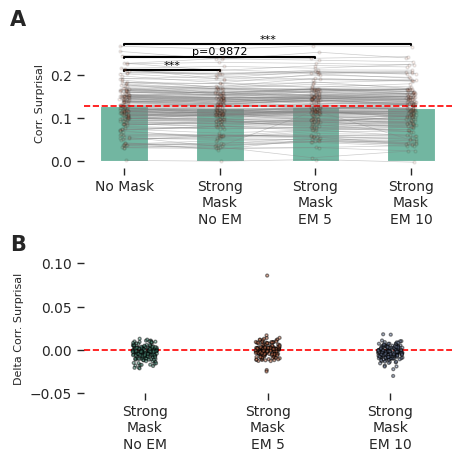

In [189]:
#fig = plt.figure(figsize=(15, 10))
rcParams.update(params_one_col)
fig, ax = plt.subplots(2, 1)


stats_test = []
minimum_data_points = 0
plot_data = seed_df.merge(rt_subj_data, on="run_id", how="left").query('data_points > @minimum_data_points').query('seed == 2347')[["condition", "subject_id", "corr_surprisal"]].query('condition in ["nomask_EM01", "ee002_EM01", "ee002_EM05", "ee002_EM10"]')
print(plot_data.shape)
plot_data_delta = plot_data[["condition", "subject_id", "corr_surprisal"]].pivot(index="subject_id", columns="condition", values="corr_surprisal")
plot_data_delta["delta_EM01"] = plot_data_delta["ee002_EM01"] - plot_data_delta["nomask_EM01"]
plot_data_delta["delta_EM05"] = plot_data_delta["ee002_EM05"] - plot_data_delta["nomask_EM01"]
plot_data_delta["delta_EM10"] = plot_data_delta["ee002_EM10"] - plot_data_delta["nomask_EM01"]

plot_data_delta = plot_data_delta[["delta_EM01", "delta_EM05", "delta_EM10"]]

#Condition Order: No Mask, Exp Mask EM 0, Exp Mask EM 5, Exp Mask EM 10
plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee002_EM01", "ee002_EM05", "ee002_EM10"], ordered=True)
plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)

sns.barplot(data=plot_data, x="condition", y="corr_surprisal", dodge=True, ax=ax[0], errorbar=None, width=0.5)
sns.stripplot(data=plot_data, x="condition", y="corr_surprisal", dodge=True, jitter=0.05, ax=ax[0], alpha=0.1, edgecolor='black', linewidth=1, size=2)
connect_dots(ax[0], alpha=0.4, linewidth=0.5)

ax[0].axhline(y=plot_data[plot_data["condition"]=="No Mask"]["corr_surprisal"].mean() , linestyle='--', color='red')

#ax.set_ylabel("BLIMP Average")
#ax.set_ylim(63, 74)  
ax[0].set_xlabel("")
ax[0].set_ylabel("Corr. Surprisal")
res = annotate_given_colid(ax[0], 1, 0, plot_data, 0.21, 0.002, "corr_surprisal", group_by="subject_id")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM01"} , **res})
res = annotate_given_colid(ax[0], 2, 0, plot_data, 0.24, 0.002, "corr_surprisal", group_by="subject_id")
stats_test.append({**{ "pair_A":"nomask_EM01", "pair_B":"ee002_EM05"} ,**res})
res = annotate_given_colid(ax[0], 3, 0, plot_data, 0.27, 0.002, "corr_surprisal", group_by="subject_id")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee002_EM10"},**res})

sns.despine(bottom=True, left=True)

plot_data_delta.rename(columns={"delta_EM01": "Strong\nMask\nNo EM", 
                                "delta_EM05": "Strong\nMask\nEM 5", 
                                "delta_EM10": "Strong\nMask\nEM 10"}, inplace=True)

sns.stripplot(data=plot_data_delta, ax=ax[1], alpha=0.5, edgecolor='black', linewidth=1, jitter=0.1, size=2)
ax[1].axhline(y=0, linestyle='--', color='red')
ax[1].set_yticks(np.arange(-0.05, 0.1, 0.05))
ax[1].set_xlabel("")
ax[1].set_ylabel("Delta Corr. Surprisal")
                               
print(pd.DataFrame(stats_test))

for n, axs in enumerate(ax.flat):
    axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, size=15, weight='bold')

save_matplot_fig(fig, "Fig7_RT_strong_mask_EM.pdf", dpi=3000)


Comparing Extreme
Mask
No EM and No Mask


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


Comparing Extreme
Mask
EM 5 and No Mask


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


Comparing Extreme
Mask
EM 10 and No Mask


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


        pair_A       pair_B  mean                      \
0  nomask_EM01  ee2000_EM01                  0.003148   
1  nomask_EM01  ee2000_EM05                 -0.001973   
2  nomask_EM01  ee2000_EM10                 -0.003465   

                           95%_CI around mean       bootstrap-t-test p_value  
0    (0.0012193772457448338, 0.0050956476309335225)                 p=0.0014  
1  (-0.003695916088535623, -0.00031944933225180265)                 p=0.0142  
2   (-0.005108491424026068, -0.0018320146088700404)               p < 0.0001  


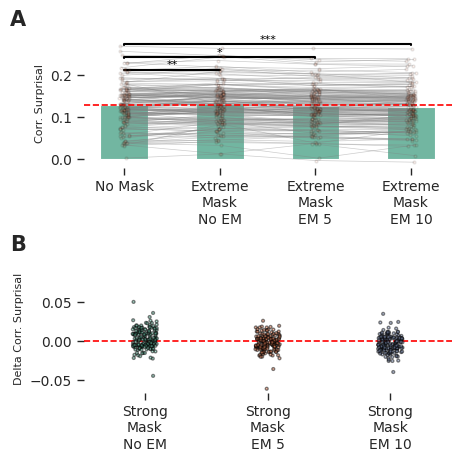

In [191]:
#fig = plt.figure(figsize=(15, 10))
rcParams.update(params_one_col)
fig, ax = plt.subplots(2, 1)


stats_test = []

plot_data = seed_df.merge(rt_subj_data, on="run_id", how="left")[["seed", "condition", "subject_id", "corr_surprisal"]].query('condition in ["nomask_EM01", "ee2000_EM01", "ee2000_EM05", "ee2000_EM10"]').query('seed == 2347')
plot_data_delta = plot_data[["condition", "subject_id", "corr_surprisal"]].pivot(index="subject_id", columns="condition", values="corr_surprisal")
plot_data_delta["delta_EM01"] = plot_data_delta["ee2000_EM01"] - plot_data_delta["nomask_EM01"]
plot_data_delta["delta_EM05"] = plot_data_delta["ee2000_EM05"] - plot_data_delta["nomask_EM01"]
plot_data_delta["delta_EM10"] = plot_data_delta["ee2000_EM10"] - plot_data_delta["nomask_EM01"]

plot_data_delta = plot_data_delta[["delta_EM01", "delta_EM05", "delta_EM10"]]

#Condition Order: No Mask, Exp Mask EM 0, Exp Mask EM 5, Exp Mask EM 10
plot_data["condition"] = pd.Categorical(plot_data["condition"], categories=["nomask_EM01", "ee2000_EM01", "ee2000_EM05", "ee2000_EM10"], ordered=True)
plot_data["condition"] = plot_data["condition"].map(condition_triplet_map)

sns.barplot(data=plot_data, x="condition", y="corr_surprisal", dodge=True, ax=ax[0], errorbar=None, width=0.5)
sns.stripplot(data=plot_data, x="condition", y="corr_surprisal", dodge=True, jitter=0.05, ax=ax[0], alpha=0.1, edgecolor='black', linewidth=1, size=2)
connect_dots(ax[0], alpha=0.4, linewidth=0.5)

ax[0].axhline(y=plot_data[plot_data["condition"]=="No Mask"]["corr_surprisal"].mean() , linestyle='--', color='red')

#ax.set_ylabel("BLIMP Average")
#ax.set_ylim(63, 74)  
ax[0].set_xlabel("")
ax[0].set_ylabel("Corr. Surprisal")
res = annotate_given_colid(ax[0], 1, 0, plot_data, 0.21, 0.002, "corr_surprisal", group_by="subject_id")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee2000_EM01"} , **res})
res = annotate_given_colid(ax[0], 2, 0, plot_data, 0.24, 0.002, "corr_surprisal", group_by="subject_id")
stats_test.append({**{ "pair_A":"nomask_EM01", "pair_B":"ee2000_EM05"} ,**res})
res = annotate_given_colid(ax[0], 3, 0, plot_data, 0.27, 0.002, "corr_surprisal", group_by="subject_id")
stats_test.append({**{"pair_A":"nomask_EM01", "pair_B":"ee2000_EM10"},**res})

sns.despine(bottom=True, left=True)

plot_data_delta.rename(columns={"delta_EM01": "Strong\nMask\nNo EM", 
                                "delta_EM05": "Strong\nMask\nEM 5", 
                                "delta_EM10": "Strong\nMask\nEM 10"}, inplace=True)

sns.stripplot(data=plot_data_delta, ax=ax[1], alpha=0.5, edgecolor='black', linewidth=1, jitter=0.1, size=2)
ax[1].axhline(y=0, linestyle='--', color='red')
ax[1].set_yticks(np.arange(-0.05, 0.1, 0.05))
ax[1].set_yticks([x for x in ax[1].get_yticks() if x <= 0.1])
ax[1].set_xlabel("")
ax[1].set_ylabel("Delta Corr. Surprisal")
                               
print(pd.DataFrame(stats_test))

for n, axs in enumerate(ax.flat):
    axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, size=15, weight='bold')

save_matplot_fig(fig, "Fig8_RT_extreme_mask_EM.pdf", dpi=3000)


Lowest validation loss seed:  6747
Number of rows before filtering:  3280
Number of rows after filtering:  328
Comparing No Curriculum and Log Curriculum


/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])
/tmp/ipykernel_1705013/4050783892.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels = ax[0].get_xticklabels())
/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping co

Comparing Log Curriculum and No Curriculum


/tmp/ipykernel_1705013/4050783892.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels( labels = ax[0].get_xticklabels())
/tmp/ipykernel_1705013/2851891860.py:210: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_diff = stats_test_subset.groupby(group_by).apply(lambda x: x[x['condition']==col_names[col_id1]][plotcolname].values[0] - x[x['condition']==col_names[col_id2]][plotcolname].values[0])


Comparing Log Curriculum and No Curriculum


/tmp/ipykernel_1705013/4050783892.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels( labels = ax[0].get_xticklabels())


          pair_A          pair_B  mean                      \
0  No Curriculum  Log Curriculum                 -0.080431   
1  No Curriculum  Log Curriculum                 -0.345788   
2  No Curriculum  Log Curriculum                  0.002498   

                       95%_CI around mean       bootstrap-t-test p_value  
0   (-0.0887544769048693, -0.07315832793712629)               p < 0.0001  
1    (-0.8929016527515016, 0.24771573502898495)                 p=0.3402  
2  (0.001224780994180568, 0.003847494187445308)               p < 0.0001  


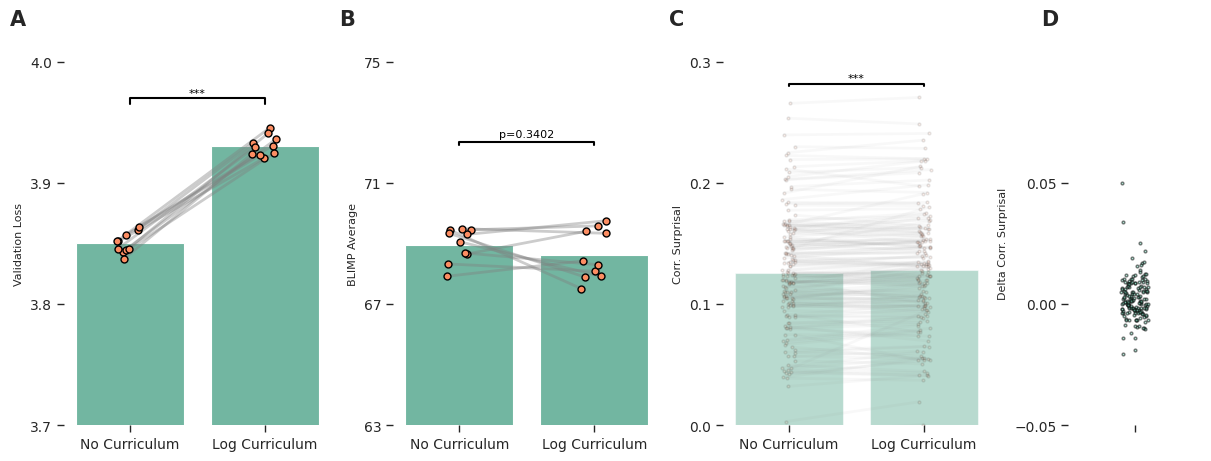

In [192]:
rcParams.update(params_two_col)

curriculum_relevant_ids = {
6892222:"No Mask",
6689752:"Log Curriculum",
}
#Filter for curriculum true and babylm_full_bpe_8k and n_layer 6
#Or Curriculum False and babylm_full_bpe_8k and n_layer 6 and mask_type = Non, and echoic_memory = 1
curriculum_run_data_unfiltered = run_data_unfiltered[((run_data_unfiltered["curriculum_learning"]==True) & (run_data_unfiltered["dataset"] == "babylm_full_bpe_8k") & (run_data_unfiltered["n_layer"]==6)& (run_data_unfiltered["curriculum_type"] == "log") ) 
                               | ((run_data_unfiltered["curriculum_learning"]==False) & (run_data_unfiltered["dataset"] == "babylm_full_bpe_8k") & (run_data_unfiltered["n_layer"]==6) & (run_data_unfiltered["mask_type"] == "Non") & (run_data_unfiltered["echoic_memory"]==1))]

#If seed is 1337, then filter for only relevant run ids, else filter for all 
curriculum_run_data_unfiltered = curriculum_run_data_unfiltered[curriculum_run_data_unfiltered.apply(lambda x: x["run_id"] in curriculum_relevant_ids.keys() if x["seed"] == 1337 else True, axis=1)]   
curriculum_run_data_unfiltered["condition"] = curriculum_run_data_unfiltered["output_folder_name"].apply(lambda x: "Log Curriculum" if "curr" in x else "No Curriculum")
curriculum_run_data_unfiltered["condition"] = pd.Categorical(curriculum_run_data_unfiltered["condition"], categories=["No Curriculum", "Log Curriculum"], ordered=True)
curriculum_run_data_unfiltered = curriculum_run_data_unfiltered.sort_values(by="condition")
#Plot label order is order of the dictionary1
curriculum_run_data_unfiltered = curriculum_run_data_unfiltered.merge(loss_data, on="run_id")
#curriculum_run_data_unfiltered = curriculum_run_data_unfiltered.merge(rt_data, on="run_id")
curriculum_run_data_unfiltered = curriculum_run_data_unfiltered.merge(blimp_data, on="run_id")
#print(curriculum_run_data_unfiltered.columns)
lowest_cur_val_loss_seed = run_data_unfiltered[((run_data_unfiltered["curriculum_learning"]==True) & (run_data_unfiltered["dataset"] == "babylm_full_bpe_8k") & (run_data_unfiltered["n_layer"]==6)& (run_data_unfiltered["curriculum_type"] == "log") )].merge(loss_data, on="run_id").sort_values(by="val_loss").head(1)["seed"].values[0]
print("Lowest validation loss seed: ", lowest_cur_val_loss_seed)

curriculum_run_data_unfiltered_rt = curriculum_run_data_unfiltered[["seed", "condition", "output_folder_name", "run_id"]].join(rt_subj_data[["run_id", "subject_id", "corr_surprisal"]].set_index("run_id"), on="run_id")
#Number of rows
print("Number of rows before filtering: ", curriculum_run_data_unfiltered_rt.shape[0])

#Filter for only the lowest validation loss seed
curriculum_run_data_unfiltered_rt = curriculum_run_data_unfiltered_rt[curriculum_run_data_unfiltered_rt["seed"] == lowest_cur_val_loss_seed]
#curriculum_run_data_unfiltered_rt=  curriculum_run_data_unfiltered_rt[[]]
print("Number of rows after filtering: ", curriculum_run_data_unfiltered_rt.shape[0])

stats = []
fig, ax = plt.subplots(1, 4, width_ratios=[2,2,2,1])

sns.barplot(data=curriculum_run_data_unfiltered, x="condition", y="val_loss", ax=ax[0], errorbar=None)
sns.stripplot(data=curriculum_run_data_unfiltered, x="condition", y="val_loss", ax=ax[0], alpha=1, edgecolor='black', linewidth=1)

connect_dots(ax[0])
ax[0].set_ylim(3.7, 4)
ax[0].set_yticks(np.arange(3.7, 4.1, 0.1))
res = annotate_given_colid(ax[0], 0, 1, curriculum_run_data_unfiltered, 3.965, 0.005, "val_loss")
stats.append({**{"pair_A":"No Curriculum", "pair_B":"Log Curriculum"} , **res})
ax[0].set_ylabel("Validation Loss")
ax[0].set_xlabel("")
ax[0].set_xticklabels(labels = ax[0].get_xticklabels())
#ax.xaxis.set_tick_params(rotation=90)

sns.barplot(data=curriculum_run_data_unfiltered, x="condition", y="blimp_avg", ax=ax[1], errorbar=None)
sns.stripplot(data=curriculum_run_data_unfiltered, x="condition", y="blimp_avg", ax=ax[1], alpha=1, edgecolor='black', linewidth=1)

connect_dots(ax[1])
ax[1].set_ylim(63,73)
ax[1].set_yticks(np.arange(63, 76, 4))
res1 = annotate_given_colid(ax[1], 1, 0, curriculum_run_data_unfiltered, 72.25, 0.1, "blimp_avg")
stats.append({**{"pair_A":"No Curriculum", "pair_B":"Log Curriculum"} , **res1})
ax[1].set_ylabel("BLIMP Average")
ax[1].set_xlabel("")
ax[1].set_xticklabels( labels = ax[0].get_xticklabels())
#sns.stripplot(data=curriculum_run_data_unfiltered, x="condition", y="corr_surprisal", ax=ax[2])
#connect_dots(ax[2])
#

sns.barplot(data=curriculum_run_data_unfiltered_rt, x="condition", y="corr_surprisal", dodge=True, alpha=.5, ax=ax[2], errorbar=None)
sns.stripplot(data=curriculum_run_data_unfiltered_rt, x="condition", y="corr_surprisal", dodge=True, jitter=0.05, ax=ax[2], alpha=0.1, edgecolor='black', linewidth=1, size=2)


connect_dots(ax[2], alpha=.05)
ax[2].set_ylim(0,0.3) 
ax[2].set_yticks(np.arange(0, 0.31, 0.1))
res2 = annotate_given_colid(ax[2], 1, 0, curriculum_run_data_unfiltered_rt, 0.28, 0.002, "corr_surprisal", group_by = "subject_id")
stats.append({**{"pair_A":"No Curriculum", "pair_B":"Log Curriculum"} , **res2})
ax[2].set_ylabel("Corr. Surprisal")
ax[2].set_xlabel("")
ax[2].set_xticklabels( labels = ax[0].get_xticklabels())



curriculum_run_data_unfiltered_rt_delta = curriculum_run_data_unfiltered_rt[["condition","subject_id", "corr_surprisal"]].pivot(index="subject_id", columns="condition", values="corr_surprisal")
curriculum_run_data_unfiltered_rt_delta["delta"] = curriculum_run_data_unfiltered_rt_delta["Log Curriculum"] - curriculum_run_data_unfiltered_rt_delta["No Curriculum"]
sns.stripplot(data=curriculum_run_data_unfiltered_rt_delta, y="delta", ax=ax[3], size=2, alpha=0.5, edgecolor='black', linewidth=1, jitter=0.1)

ax[3].set_ylabel("Delta Corr. Surprisal")
ax[3].set_xlabel("")
ax[3].set_ylim(-0.05, 0.1)
ax[3].set_yticks(np.arange(-0.05, 0.099, 0.05))
for n, axs in enumerate(ax.flat):
    axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, size=15, weight='bold')
sns.despine(bottom=True, left=True)

#save_matplot_fig(fig, "Fig9_curriculum_effects.pdf", dpi=3000)
print(pd.DataFrame(stats))

# Appendix Stuff

In [94]:
#Ignoring following runs because dupes 
run_data_unfiltered.query("run_id in [5734459, 5496427, 6617787, 6681949]")

,run_id,output_folder_name,n_layer,n_head,block_size,n_embd,batch_size,learning_rate,seed,masking,...,curriculum_type,dataset,log_exists,output_exists,ckpt_exists,sample_exists,blimp_exists,wandb_exists,reading_time_exists,model_surprisal_data_exists
5,5496427,out-babylm_full_bpe_8k-6x6-nomask-5496427,6,6,256,384,32.0,0.0005,1337,False,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True
6,5734459,out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True
27,6617787,out-babylm_full_bpe_8k-6x6-mask_log001-6617787,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,False
43,6681949,out-babylm_full_bpe_8k-6x6-mask_log002_em10-66...,6,6,256,384,32.0,0.0005,1337,True,...,NaN,babylm_full_bpe_8k,True,True,True,True,True,True,True,True


/tmp/ipykernel_1705013/1467538691.py:17: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=appendix_loss_df, x="condition", y="Validation Loss", hue="Echoic Memory", ax=ax[0], palette=sns.color_palette("Set2"))


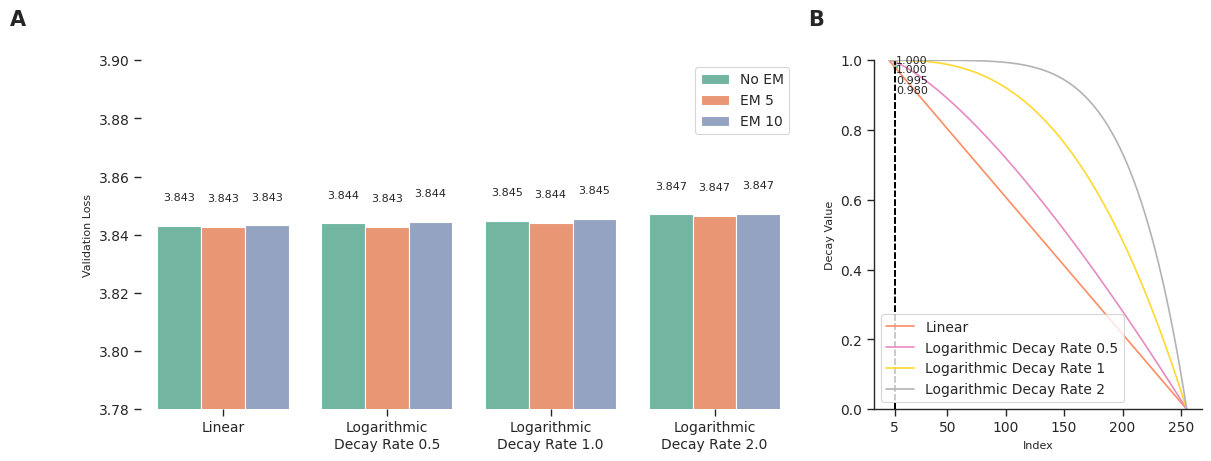

In [185]:
rcParams.update(params_two_col)


appendix_loss_df = (run_data_unfiltered[(run_data_unfiltered["n_head"]==6) & (run_data_unfiltered["n_layer"]==6) & (run_data_unfiltered["dataset"]=="babylm_full_bpe_8k") & (run_data_unfiltered["mask_type"].isin(["linear", "logarithmic"])) & (run_data_unfiltered["curriculum_learning"] == False) & (run_data_unfiltered["seed"] == 1337)
].merge(loss_data, on="run_id").query("run_id not in [5734459, 5496427, 6617787, 6681949]").sort_values(by=["mask_type", "mask_decay_rate", "echoic_memory"]))
appendix_loss_df["condition"] = (appendix_loss_df["mask_type"].map({"linear": "Linear\n", "logarithmic": "Logarithmic\n"}) + "Decay Rate "
                                 + appendix_loss_df["mask_decay_rate"].astype(str))
appendix_loss_df.rename(columns={"val_loss": "Validation Loss",
                                 "echoic_memory": "Echoic Memory"}, inplace=True)

#If  condition is Linear Decay Rate 0.0, rename it to Linear

appendix_loss_df["condition"] = appendix_loss_df["condition"].apply(lambda x: "Linear" if "Linear" in x else x)


fig, ax = plt.subplots(1, 2, width_ratios=[2,1])
sns.barplot(data=appendix_loss_df, x="condition", y="Validation Loss", hue="Echoic Memory", ax=ax[0], palette=sns.color_palette("Set2"))
#ax.axhline(y=run_data.query("run_id == 6892222").merge(loss_data, on="run_id")["val_loss"].values[0], linestyle="--", color="red", label = "No Mask Validation Loss")
#y = run_data.query("run_id == 6892222").merge(loss_data, on="run_id")["val_loss"].values[0].round(4)
#ax.text(ax.get_xlim()[1] + 0.1, y, f'Validation Loss\nNo Mask\n={y}', va='center')
                                   
ax[0].set_ylim(3.78, 3.9)
ax[0].set_xlabel("")
for p in ax[0].patches:
    ax[0].annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()+0.005),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#Edit legend
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=["No EM", "EM 5", "EM 10"])

ax[1] = ret_chart_3(fig, ax[1], option_1 = False)
sns.despine(bottom=True, left=True, ax=ax[0])
sns.despine(ax=ax[1])

for n, axs in enumerate(ax.flat):
    axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, size=15, weight='bold')
    
save_matplot_fig(fig, "Appendix_Fig1_val_loss.pdf", dpi=3000)

In [116]:
appendix_loss_df

,run_id,output_folder_name,n_layer,n_head,block_size,n_embd,batch_size,learning_rate,seed,masking,...,ckpt_exists,sample_exists,blimp_exists,wandb_exists_x,reading_time_exists,model_surprisal_data_exists,wandb_exists_y,train_loss,val_loss,condition
14,6810326,out-babylm_full_bpe_8k-6x6-mask_lin_em01-6810326,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.888309,3.843170,Linear\nDecay Rate 0.0
3,6681938,out-babylm_full_bpe_8k-6x6-mask_lin_em05-6681938,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.888227,3.842720,Linear\nDecay Rate 0.0
5,6681941,out-babylm_full_bpe_8k-6x6-mask_lin_em10-6681941,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.888577,3.843202,Linear\nDecay Rate 0.0
13,6810323,out-babylm_full_bpe_8k-6x6-mask_log0p5_em01-68...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.888089,3.843926,Logarithmic\nDecay Rate 0.5
9,6681950,out-babylm_full_bpe_8k-6x6-mask_log0p5_em05-66...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.888701,3.842633,Logarithmic\nDecay Rate 0.5
10,6681951,out-babylm_full_bpe_8k-6x6-mask_log0p5_em10-66...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.889655,3.844366,Logarithmic\nDecay Rate 0.5
11,6810205,out-babylm_full_bpe_8k-6x6-mask_log001_em01-68...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.893456,3.844766,Logarithmic\nDecay Rate 1.0
2,6681937,out-babylm_full_bpe_8k-6x6-mask_log001_em05-66...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.895009,3.844028,Logarithmic\nDecay Rate 1.0
4,6681940,out-babylm_full_bpe_8k-6x6-mask_log001_em10-66...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.894181,3.845482,Logarithmic\nDecay Rate 1.0
12,6810320,out-babylm_full_bpe_8k-6x6-mask_log002_em01-68...,6,6,256,384,32.0,0.0005,1337,True,...,True,True,True,True,True,True,True,2.895885,3.847029,Logarithmic\nDecay Rate 2.0


In [117]:
run_data.query("run_id == 6892222").merge(loss_data, on="run_id")

,run_id,output_folder_name,n_layer,n_head,block_size,n_embd,batch_size,learning_rate,seed,masking,...,output_exists,ckpt_exists,sample_exists,blimp_exists,wandb_exists_x,reading_time_exists,model_surprisal_data_exists,wandb_exists_y,train_loss,val_loss
0,6892222,out-babylm_full_bpe_8k-6x6-nomask-6892222_s1337,6,6,256,384,32.0,0.0005,1337,False,...,True,True,True,True,True,True,True,True,2.897251,3.845519
